In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
import math
import pandas as pd
import random

In [2]:
#Contour plot for beale function
def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(np.array([x,y]),features=0,target=0)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax


#Utility to plot beales contours
def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r", xlimL=1, xlimH=1, ylimL=1, ylimH=1, zlimL=2, zlimH=2):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-xlimL, xlimH)
    ax.set_ylim(-ylimL, ylimH)
    ax.set_zlim(-zlimL, zlimH)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;



def overlay_trajectory(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;


##Beale function

$$
z = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

With absolute minimum in 

$$(\hat{x},\hat{y})=(3,0.5)$$

In [3]:
#Beale function
def beales_function(theta,features,target):
    x=theta[0]
    y=theta[1]
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    

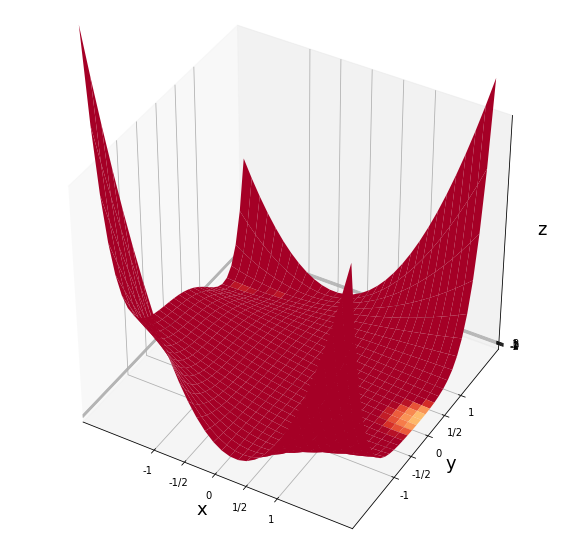

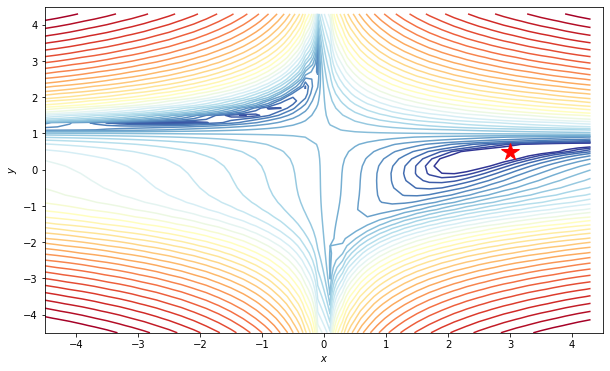

In [4]:
#Plot 3D Beale function
x, y = np.mgrid[-2:2:31j, -2:2:31j] 
fig,ax=plot_surface(x,y,beales_function(np.array([x,y]),features=0,target=0),xlimL=2.1, xlimH=2.1, ylimL=2.1, ylimH=2.1, zlimL=0,zlimH=300)

#Beale function contour plot
fig1,ax1 =contour_beales_function()
plt.show()

#Approaching Gradient Descent

##Define updating thetas functions

In [5]:
def vanilla_descent(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,noise_var):
  grad=gradient(target,features,theta)
  theta=theta-lr*grad*np.random.normal(1,noise_var,1)
  return [theta,0]

In [6]:
def RK_2_adaptive_gradient(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,noise_var):
  g=gradient(target,features,theta)
  theta_hat=theta-lr*g*np.random.normal(1,noise_var,1)
  g_tilde=gradient(target,features,theta_hat)*np.random.normal(1,noise_var,1)
  
  prod=np.dot(np.reshape((g-g_tilde),(g.shape[0])), np.reshape((g),(g.shape[0])))
  
  tentative= 2*lr*prod/(np.linalg.norm(g-g_tilde)**2)
  if prod>0:
    lr_opt=tentative
  else:
    lr_opt=lr

  if lr_opt>=lr:
    lr=beta*lr+(1-beta)*lr_opt
  else:
    lr=(1-beta)*lr_opt
  
  theta=theta-lr*g
  
  return [theta,0]

In [7]:
def RK4(theta,target, features,lr,loss,gradient,beta,n_iter,t, theta_p,noise_var):
     
    c = lr*100# 0.05  
    lr = (c/n_iter**(1/5))
    
    k1 = lr*gradient(target,features,theta)*np.random.normal(1,noise_var,1)

    theta0 = theta - (1/2*lr*k1)
    k2=lr*gradient(target,features,theta)*np.random.normal(1,noise_var,1)
    
    
    theta0 -= (1/2*lr*k2)
    k3 = lr*gradient(target,features,theta)*np.random.normal(1,noise_var,1)
    
    theta0 -= (1/2*lr*k3)
    k4 = lr*gradient(target,features,theta)*np.random.normal(1,noise_var,1)
    
    gradi = (k1/6 + k2/3 + k3/3 + k4/6)#*lr
    theta = theta - gradi
    
    return [theta,0]

In [8]:
#https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12
def NAG (theta, target,features,lr,loss, gradient_f, beta, n_iter, t, theta_p,noise_var):
    #=a quale iterazione stiamo, theta_previous=theta_{t-1}-->s_{t-1}
    mu_s = [0.999,0.995,0.99,0.9,0] 
    mu_max = mu_s[-2]               #aumentando mu_max migliora al convergenza
    mu = min(1-2**(-1-math.log2(t/250 +1)), mu_max) #https://towardsdatascience.com/learning-parameters-part-4-6a18d1d3000b
    
    theta_a = theta - mu*theta_p
    update_t = mu * theta_p  + lr*gradient_f(target,features,theta_a)*np.random.normal(1,noise_var,1)
    theta = theta - update_t
    
    return [theta, update_t]


##Define gradient function

In [9]:
def beales_gradient(target,features,theta):
  x=theta[0]
  y=theta[1]
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
  grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
  grad=np.array([grad_x,grad_y])
  
  return(grad)

##Define gradient ascent function

In [10]:
def gradient_descent(theta, features, target, lr, num_steps,loss,GD_type,gradient_function,beta, n_iter,t, theta_p,noise_var):  
    loss_history = np.zeros(num_steps)
    parameter_traj=np.zeros((num_steps,theta[0].shape[0]))


    for step in range(num_steps):
        parameter_traj[step]=np.reshape(theta[0],theta[0].shape[0])
        loss_history[step]=loss(theta[0],features,target)
        theta = GD_type(theta[0], target, features, lr,loss,gradient_function,beta,n_iter,t=step, theta_p=theta[1],noise_var=noise_var)
        
    return theta, loss_history, parameter_traj

##Test different updating functions

In [11]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]


theta0 = [np.array([2,2]),0]
noise_var=0 

#Run Gradient Ascent method
n_iter=1000
theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                        num_steps=n_iter,loss=beales_function,
                                                        GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                        beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=NAG,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=RK4,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                   beta=0.01, n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

print(theta_final_RK2, theta_final_RK4, theta_final_NAG, theta_final_vanilla)


[array([2.99999899, 0.49999976]), 0] [array([2.76327629, 0.43441536]), 0] [array([2.4337766 , 0.31895646]), array([-0.00042497, -0.00016837])] [array([2.06974609, 0.27067801]), 0]


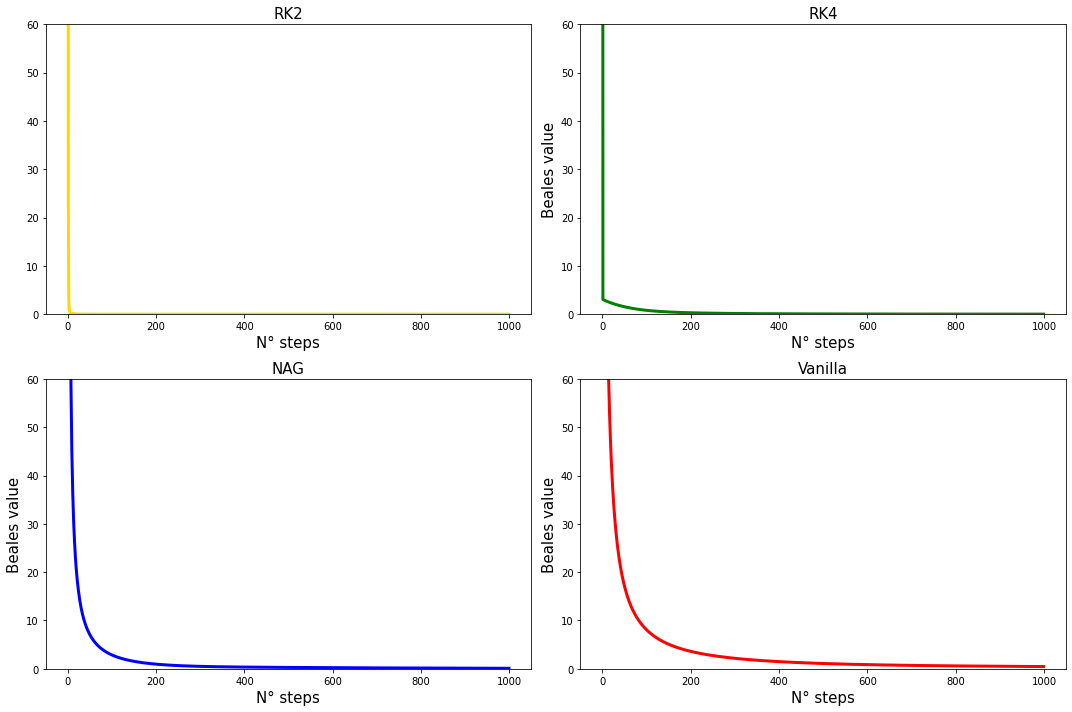

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(log_l_history_RK2,color="gold",linewidth=3)
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax1.set_ylim([0, 60])

ax2.plot(log_l_history_RK4,color="green",linewidth=3)
ax2.set_title("RK4",fontsize=15)
ax2.set_ylabel("Beales value",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_ylim([0, 60])

ax3.plot(log_l_history_NAG,color="blue",linewidth=3)
ax3.set_title("NAG",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_ylim([0, 60])

ax4.plot(log_l_history_vanilla,color="red",linewidth=3)
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_ylabel("Beales value",fontsize=15)
ax4.set_ylim([0, 60])

fig.tight_layout()


plt.show()

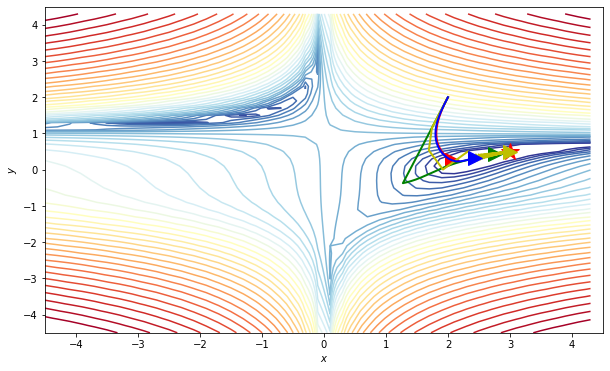

In [13]:
fig1, ax1=contour_beales_function()
overlay_trajectory(ax1,descent_trajectory_vanilla, 'Vanilla','r')
overlay_trajectory(ax1,descent_trajectory_RK4, 'RK','g')
overlay_trajectory(ax1,descent_trajectory_RK2, 'RK','y')
overlay_trajectory(ax1,descent_trajectory_NAG, 'NAG','b')

plt.show()



#Noise injection


In [14]:
# Initialize theta0
#inizializzazioni da dove convergiamo meglio
#[-1,-1],[3,-3],[3,3],[-1,-4]
random.seed(10)

theta0 = [np.array([2,2]),0]
noise_var=3

# Run Gradient Ascent method
n_iter=1000
theta_final_vanilla, log_l_history_vanilla,descent_trajectory_vanilla = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                        num_steps=n_iter,loss=beales_function,
                                                        GD_type=vanilla_descent,gradient_function=beales_gradient,
                                                        beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

theta_final_NAG, log_l_history_NAG,descent_trajectory_NAG = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=NAG,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

theta_final_RK4, log_l_history_RK4,descent_trajectory_RK4 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=RK4,gradient_function=beales_gradient,
                                                   beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

theta_final_RK2, log_l_history_RK2,descent_trajectory_RK2 = gradient_descent(theta0,features=theta0,target=theta0,lr=0.0001,
                                                   num_steps=n_iter,loss=beales_function,
                                                   GD_type=RK_2_adaptive_gradient,gradient_function=beales_gradient,
                                                   beta=0.01, n_iter=n_iter,t=0, theta_p=0,noise_var=noise_var)

print(theta_final_RK2, theta_final_RK4, theta_final_NAG, theta_final_vanilla)


[array([2.18447595, 0.22808517]), 0] [array([2.76347386, 0.43447604]), 0] [array([2.41032373, 0.30961182]), array([1.36985932e-05, 5.15713706e-06])] [array([2.05035949, 0.26426728]), 0]


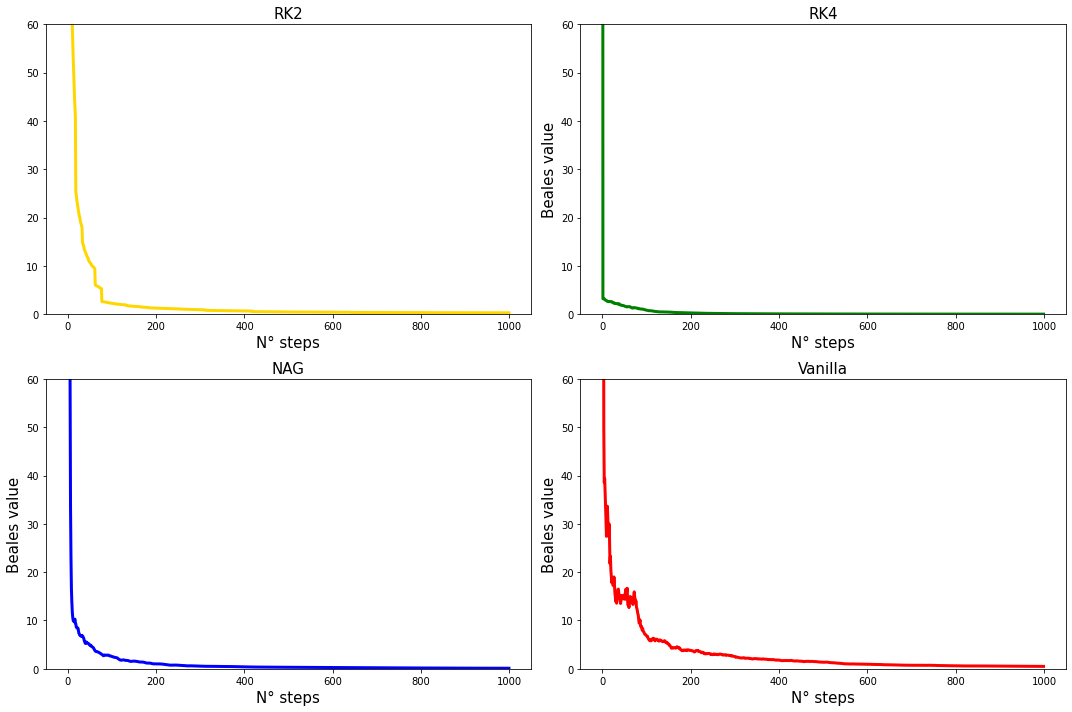

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(log_l_history_RK2,color="gold",linewidth=3)
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax1.set_ylim([0, 60])

ax2.plot(log_l_history_RK4,color="green",linewidth=3)
ax2.set_title("RK4",fontsize=15)
ax2.set_ylabel("Beales value",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_ylim([0, 60])

ax3.plot(log_l_history_NAG,color="blue",linewidth=3)
ax3.set_title("NAG",fontsize=15)
ax3.set_ylabel("Beales value",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_ylim([0, 60])

ax4.plot(log_l_history_vanilla,color="red",linewidth=3)
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_ylabel("Beales value",fontsize=15)
ax4.set_ylim([0, 60])

fig.tight_layout()


plt.show()

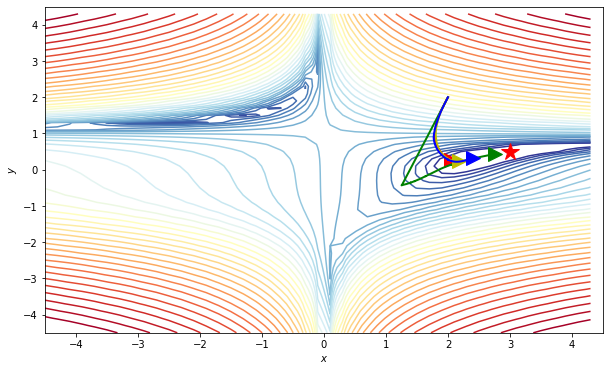

In [16]:
fig1, ax1=contour_beales_function()
overlay_trajectory(ax1,descent_trajectory_vanilla, 'Vanilla','r')
overlay_trajectory(ax1,descent_trajectory_RK4, 'RK','g')
overlay_trajectory(ax1,descent_trajectory_RK2, 'RK','y')
overlay_trajectory(ax1,descent_trajectory_NAG, 'NAG','b')

plt.show()



#Over the Titanic dataset

### Processing the test dataset

The values of `Sex` and `Embarked` (port of embarkation) are transformed into integeres with the following correspondence:
- Sex:
    - `male` -> `0`
    - `female` -> `1`
- Embarked:
    - `C` -> `-1`
    - `Q` -> `0`
    - `S` -> `1`

In [17]:
# Importing the data and dropping features uncorrelated with survival outcome
unprocessed_training_dataset = pd.read_csv("train.csv", index_col='PassengerId')
training_dataset = unprocessed_training_dataset.drop(columns=["Ticket", 'Cabin', 'Name'])

#Normalizing with the mean the Age and Fare values
training_dataset['Age'] = ((training_dataset['Age'] - training_dataset['Age'].mean()) / training_dataset['Age'].max())
training_dataset['Fare'] = ((training_dataset['Fare'] - training_dataset['Fare'].mean()) / training_dataset['Fare'].max())

# Droppig passangers with missing values
training_dataset = training_dataset.dropna(subset=["Embarked", "Age"])

# Discretizing the `Sex` and `Embarked` values
training_dataset['Sex'] = training_dataset['Sex'].replace(to_replace=["male", "female"], value=[0, 1])
training_dataset['Embarked'] = training_dataset['Embarked'].replace(to_replace=["C", "Q", "S"], value=[-1, 0, 1])

# Transforming the dataset in numpy arrays to implement the gradient ascent
training_data_matrix = training_dataset.drop(columns='Survived').to_numpy()
target_array = training_dataset['Survived'].to_numpy().reshape((-1, 1))

# adding a column on ones for to the data matrix corresponding to the coventional x0 feture
column_of_ones = np.ones(shape=(training_data_matrix.shape[0], 1))
training_data_matrix = np.hstack((column_of_ones, training_data_matrix))

# Visualizing the first elements of the training_dataset
training_dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,-0.096239,1,0,-0.048707,1
2,1,1,1,0.103761,1,0,0.076277,-1
3,1,3,1,-0.046239,0,0,-0.047390,1
4,1,1,1,0.066261,1,0,0.040786,1
5,0,3,0,0.066261,0,0,-0.047146,1


### Computing the paramenters

In [18]:
def log_likelihood(theta,features,target):
    '''
    Function to compute the log likehood of theta according to data x and label y
    
    Input:
    theta: it's the model parameter matrix.
    features: it's the input data matrix. The shape is (N, H)
    target: the label array
    
    Output:
    log_g: the log likehood of theta according to data x and label y
    '''
      
    log_l=((target * np.log(1 / (1 + np.exp(-features @ theta)))+(1-target)*np.log(1-1 / (1 + np.exp(-features @ theta)))).sum()) / len(features)

    return log_l

def log_likelihood_gradient(target,features,theta):

  log_lik_deriv = (((target - 1 / (1 + np.exp(-features @ theta))).transpose() @ features).transpose() / len(features))
  return log_lik_deriv

def predictions(features, theta):
    '''
    Function to compute the predictions for the input features
    
    Input:
    theta: it's the model parameter matrix.
    features: it's the input data matrix. The shape is (N, H)
    
    Output:
    preds: the predictions of the input features
    '''
      
    response=1 / (1 + np.exp(-features @ theta))
    preds = np.where(response >=0.5, 1, 0)
    return preds

##Comparing performances gradient descent performances

*   Vanilla descent;
*   RK-2 Adaptive learning rate: an exact $\frac{1}{N^2}$ rate
*   RK-4 descent, approaching $\frac{1}{N^2}$ leveraging the order of the RK integrator
*   The optimal benchmark: NAG descent



In [19]:
# Initialize theta0
theta0 = [np.zeros((training_data_matrix.shape[1], 1)),0] # 1dimensional verical array of shape (8, 1) 

# Run Gradient Ascent method
n_iter=2000

theta_final_vanilla,log_l_history_vanilla,trajectory_vanilla=gradient_descent(theta0,features=training_data_matrix,target=target_array,lr=-.05 ,
                                                                              num_steps=n_iter,loss=log_likelihood,
                                                                              GD_type=vanilla_descent,gradient_function=log_likelihood_gradient,
                                                                              beta=0.01,n_iter=n_iter,t=0, theta_p=0,noise_var=0)

theta_final_RK2,log_l_history_RK2,trajectory_RK2=gradient_descent(theta0,features=training_data_matrix,target=target_array,lr=-.05 ,
                                                                  num_steps=n_iter,loss=log_likelihood,
                                                                  GD_type=RK_2_adaptive_gradient,gradient_function=log_likelihood_gradient,
                                                                  beta=0.1,n_iter=n_iter,t=0, theta_p=0,noise_var=0)

theta_final_RK4,log_l_history_RK4,trajectory_RK4=gradient_descent(theta0,features=training_data_matrix,target=target_array,lr=-.05 ,
                                                                  num_steps=n_iter,loss=log_likelihood,
                                                                  GD_type=RK4,gradient_function=log_likelihood_gradient,
                                                                  beta=0.1,n_iter=n_iter,t=0, theta_p=0,noise_var=0)

theta_final_NAG,log_l_history_NAG,trajectory_NAG=gradient_descent(theta0,features=training_data_matrix,target=target_array,lr=-.05 ,
                                                                  num_steps=n_iter,loss=log_likelihood,
                                                                  GD_type=NAG,gradient_function=log_likelihood_gradient,
                                                                  beta=0.1,n_iter=n_iter,t=0, theta_p=0,noise_var=0)

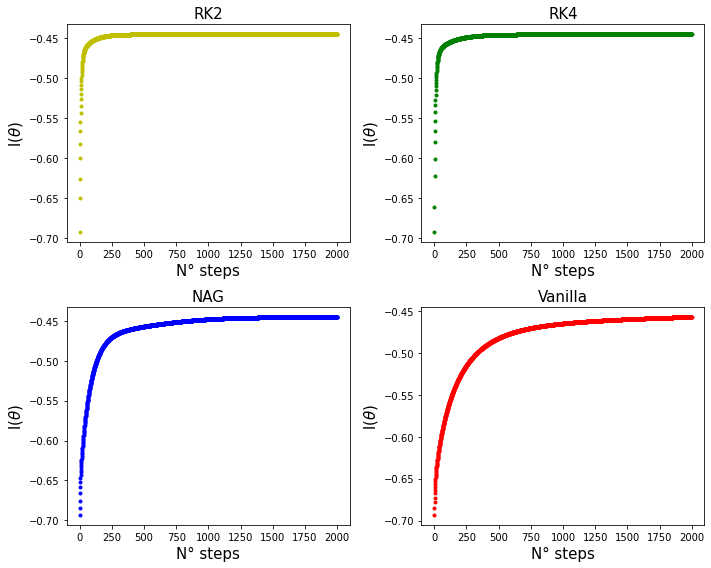

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8))
ax1.plot(log_l_history_RK2,"y.")
ax1.set_title("RK2",fontsize=15)
ax1.set_xlabel("N° steps",fontsize=15)
ax1.set_ylabel(r'l($\theta$)',fontsize=15)

ax2.plot(log_l_history_RK4,"g.")
ax2.set_title("RK4",fontsize=15)
ax2.set_xlabel("N° steps",fontsize=15)
ax2.set_ylabel(r'l($\theta$)',fontsize=15)

ax3.plot(log_l_history_NAG,"b.")
ax3.set_title("NAG",fontsize=15)
ax3.set_xlabel("N° steps",fontsize=15)
ax3.set_ylabel(r'l($\theta$)',fontsize=15)

ax4.plot(log_l_history_vanilla,"r.")
ax4.set_title("Vanilla",fontsize=15)
ax4.set_xlabel("N° steps",fontsize=15)
ax4.set_ylabel(r'l($\theta$)',fontsize=15)

fig.tight_layout()
plt.show()

### Processing the test set

In [21]:
# Importing the data and dropping features uncorrelated with survival outcome
unprocessed_test_dataset = pd.read_csv("test.csv", index_col='PassengerId')
test_dataset = unprocessed_test_dataset.drop(columns=["Ticket", 'Cabin', 'Name'])

#Normalizing with the mean the Age and Fare values
test_dataset['Age'] = ((test_dataset['Age'] - test_dataset['Age'].mean()) / test_dataset['Age'].max())
test_dataset['Fare'] = ((test_dataset['Fare'] - test_dataset['Fare'].mean()) / test_dataset['Fare'].max())

# Droppig passangers with missing values
test_dataset = test_dataset.dropna(subset=["Embarked", "Age"])

# Discretizing the `Sex` and `Embarked` values
test_dataset['Sex'] = test_dataset['Sex'].replace(to_replace=["male", "female"], value=[0, 1])
test_dataset['Embarked'] = test_dataset['Embarked'].replace(to_replace=["C", "Q", "S"], value=[-1, 0, 1])

# Transforming the dataset in numpy arrays to implement the gradient ascent
test_data_matrix = test_dataset.to_numpy()


# adding a column on ones for to the data matrix corresponding to the coventional x0 feture
column_of_ones = np.ones(shape=(test_data_matrix.shape[0], 1))
test_data_matrix = np.hstack((column_of_ones, test_data_matrix))

### Computing the predictions

In [22]:
# Computing the predictions and storing them into an array
survived_array = predictions(test_data_matrix, theta_final_vanilla[0]).flatten()

# Inserting the predictions into the Test Dataframe
Survived_series = pd.Series(data=survived_array, name='Survived', index=test_dataset.index)
Survived_series.to_csv("predictions.csv")
print(f"The accuracy computed by Kaggle is 0.77")



The accuracy computed by Kaggle is 0.77
